## Изучение данных

In [79]:
import json
import pandas as pd
import numpy as np

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from phik import report

import catboost as cb
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from catboost import CatBoostClassifier
from sklearn.utils import shuffle

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

In [2]:
f = open('features_types.json')
features_types = json.load(f)

In [3]:
data_features = pd.DataFrame(features_types.items(), columns=['features', 'types'])
data_features.head()

,features,types
0,markers_0_1_cnt,numeric
1,markers_1_1_cnt,numeric
2,markers_2_1_cnt,numeric
3,markers_3_1_cnt,numeric
4,markers_4_1_cnt,numeric


Создадим отдельно таргет.

In [4]:
target=['target']

In [5]:
target = pd.read_parquet('dataset_train.parquet', engine='pyarrow', columns=target)
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   target  702086 non-null  int32
dtypes: int32(1)
memory usage: 2.7 MB


In [6]:
target.value_counts()

target
0         696617
1           5469
dtype: int64

Выбираю только свою часть признаков.

In [7]:
my_data_features = data_features.iloc[930:1860]

In [8]:
my_data_features.types.value_counts()

numeric            851
categorical_int     69
categorical_str     10
Name: types, dtype: int64

In [9]:
my_data_features.head()

,features,types
930,vas_details_1_3_sum,numeric
931,vas_details_2_6_sum,numeric
932,vas_details_3_1_sum,numeric
933,vas_details_4_3_sum,numeric
934,vas_details_5_6_sum,numeric


In [10]:
my_data_features_num = my_data_features[my_data_features['types'] == 'numeric']

In [11]:
my_data_features_cat = my_data_features[my_data_features['types'] != 'numeric']

In [12]:
my_data_features_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 851 entries, 930 to 1859
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   features  851 non-null    object
 1   types     851 non-null    object
dtypes: object(2)
memory usage: 19.9+ KB


## Обработка и удаление лишних числовых признаков

In [13]:
def read_data(left, right):

    # следующие т столбцов, которые будем считывать + target
    columns_to_read = my_data_features_num['features'][left:right].to_list() + ['target']

    # считываем столбцы в файл
    data = pd.read_parquet('dataset_train.parquet', engine='pyarrow', columns=columns_to_read)

    return data

def variance_filter(data, threshold=0.5):

    # считаем дисперсию для каждого признака
    variance = data.var()

    # отбираем те фичи, у которых var > threshold
    selected_features = variance[variance > threshold].index.tolist()

    # собираем в датасет
    filtered_data = data[selected_features + ['target']]
    
    return filtered_data


def corr_with_target(data):

    # чекаем корреляцию с таргетом
    correlation = data.corrwith(data['target']).abs()
    
    # сортируем
    correlation = correlation.sort_values(ascending=False)
    
    return correlation


def common_correlation(data, threshold=0.9):
    corr_matrix = data.corr().abs()
    
    # выбираем верхний треугольник матрицы корреляции
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    
    # находим индексы признаков с корреляцией больше 0.90, удаляем один из них
    to_drop = []
    for i in range(len(upper.columns)):
        for j in range(i):
            if upper.iloc[j, i] >= threshold:
                if upper.columns[i] not in to_drop:
                    to_drop.append(upper.columns[j])
    
    # удаляем эти признаки из датафрейма
    data.drop(to_drop, axis=1, inplace=True)
    
    return data


def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

Создадим датасет с числовыми признаками.

In [14]:
dataset_num = read_data(0, -1)
dataset_num.head()

,vas_details_1_3_sum,vas_details_2_6_sum,vas_details_3_1_sum,vas_details_4_3_sum,vas_details_5_6_sum,vas_details_6_1_sum,vas_details_7_3_sum,vas_details_8_6_sum,vas_details_9_1_sum,vas_details_10_3_sum,...,issues_47_6_sum,issues_48_1_sum,issues_49_3_sum,issues_50_6_sum,issues_51_1_sum,issues_52_3_sum,issues_53_6_sum,issues_54_1_sum,issues_55_3_sum,target
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [15]:
dataset_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 851 entries, vas_details_1_3_sum to target
dtypes: float64(850), int32(1)
memory usage: 4.4 GB


Теперь категориальные:

In [16]:
columns_to_read = my_data_features_cat['features'].to_list()

dataset_cat = pd.read_parquet('dataset_train.parquet', engine='pyarrow', columns=columns_to_read)

In [17]:
dataset_cat.head()

,communication_availability_4_1_flg,communication_availability_5_1_flg,communication_availability_6_1_flg,social_dem_0_0_flg,communication_availability_7_1_ctg,communication_availability_8_1_flg,communication_availability_9_1_flg,communication_availability_10_1_ctg,communication_availability_11_1_flg,communication_availability_12_1_flg,...,tariff_plans_17_src_id,deact_react_5_1_ctg,communication_availability_45_1_flg,user_active_4_1_flg,deact_react_7_1_ctg,exist_tariff_1_1_flg,tariff_plans_18_1_ctg,tariff_plans_19_src_id,deact_react_8_1_ctg,deact_react_10_1_ctg
0,1,1,1,-1,4,0,0,50,1,0,...,-1,0,1,1,0,0,4055,51551,-1,0
1,1,1,1,-1,4,0,0,50,1,0,...,-1,0,1,1,0,0,4055,51551,-1,0
2,1,1,1,-1,5,0,0,100,0,0,...,-1,0,1,1,0,0,3755,51529,-1,0
3,1,1,1,-1,4,0,0,100,0,0,...,-1,0,1,1,0,0,3637,51412,-1,0
4,1,1,1,-1,4,0,0,100,0,0,...,-1,0,1,1,0,0,2601,51675,-1,0


In [18]:
dataset_cat = dataset_cat.astype('category')

In [19]:
dataset_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 79 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   communication_availability_4_1_flg   702086 non-null  category
 1   communication_availability_5_1_flg   702086 non-null  category
 2   communication_availability_6_1_flg   702086 non-null  category
 3   social_dem_0_0_flg                   702086 non-null  category
 4   communication_availability_7_1_ctg   702086 non-null  category
 5   communication_availability_8_1_flg   702086 non-null  category
 6   communication_availability_9_1_flg   702086 non-null  category
 7   communication_availability_10_1_ctg  702086 non-null  category
 8   communication_availability_11_1_flg  702086 non-null  category
 9   communication_availability_12_1_flg  702086 non-null  category
 10  communication_availability_13_1_flg  702086 non-null  category
 11  

Объединим их:

In [20]:
my_data = dataset_num.join(dataset_cat)

In [21]:
my_data.head()

,vas_details_1_3_sum,vas_details_2_6_sum,vas_details_3_1_sum,vas_details_4_3_sum,vas_details_5_6_sum,vas_details_6_1_sum,vas_details_7_3_sum,vas_details_8_6_sum,vas_details_9_1_sum,vas_details_10_3_sum,...,tariff_plans_17_src_id,deact_react_5_1_ctg,communication_availability_45_1_flg,user_active_4_1_flg,deact_react_7_1_ctg,exist_tariff_1_1_flg,tariff_plans_18_1_ctg,tariff_plans_19_src_id,deact_react_8_1_ctg,deact_react_10_1_ctg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,0,1,1,0,0,4055,51551,-1,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,0,1,1,0,0,4055,51551,-1,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,0,1,1,0,0,3755,51529,-1,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,0,1,1,0,0,3637,51412,-1,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,0,1,1,0,0,2601,51675,-1,0


In [22]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 930 entries, vas_details_1_3_sum to deact_react_10_1_ctg
dtypes: category(79), float64(850), int32(1)
memory usage: 4.5 GB


Удалим столбцы, где больше 1/10 пропусков.

In [23]:
my_data.dropna(thresh=len(my_data)/10, axis=1, inplace=True)

In [24]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 925 entries, vas_details_1_3_sum to deact_react_10_1_ctg
dtypes: category(79), float64(845), int32(1)
memory usage: 4.5 GB


Фильтруем по дисперсии.

In [25]:
my_data = variance_filter(my_data)

In [26]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 753 entries, vas_details_1_3_sum to target
dtypes: float64(752), int32(1)
memory usage: 3.9 GB


Чекаем корреляцию с таргетом:

In [27]:
corr_with_target(my_data)

target                         1.000000
movix_channels_105_1_sumpct    0.038317
movix_channels_106_3_sumpct    0.038317
movix_channels_107_6_sumpct    0.038317
movix_channels_3_1_part        0.030670
                                 ...   
spas_symptoms_int_159_1_cnt    0.000049
spas_symptoms_int_60_1_cnt     0.000040
issues_22_3_sum                0.000029
traffic_details_34_1d6_avg     0.000021
traffic_details_60_1_avg       0.000020
Length: 753, dtype: float64

Удаляем 1 признак из каждой пары коррелирующих признаков.

In [28]:
common_correlation(my_data)

,vas_details_5_6_sum,vas_details_6_1_sum,vas_details_7_3_sum,vas_details_8_6_sum,vas_details_18_1_mean,vas_details_19_1d3_mean,vas_details_20_1d6_mean,vas_details_22_3d6_mean,vas_details_23_6_mean,vas_details_24_1_meanpct,...,issues_47_6_sum,issues_48_1_sum,issues_49_3_sum,issues_50_6_sum,issues_51_1_sum,issues_52_3_sum,issues_53_6_sum,issues_54_1_sum,issues_55_3_sum,target
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.484357,-0.083936,-0.167973,-0.22824,-0.028022,-0.049234,-0.05957,-0.014744,-0.026752,0
702082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
702083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
702084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Дропаем дубликаты.

In [29]:
my_data.drop_duplicates(inplace=True)

In [30]:
my_data['target'].value_counts()

0    696446
1      5469
Name: target, dtype: int64

## Важность признаков

Выделим таргет и проведем даунсемплинг, затем посмотрим на важность признаков, обучив модель.

In [31]:
features = my_data.drop(['target'], axis=1)
target = my_data['target']

In [32]:
features_downsampled, target_downsampled = downsample(features, target, 0.01)

### LGBM

In [63]:
model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(features_downsampled, target_downsampled)

LGBMClassifier(random_state=42)

In [64]:
lgbm_imp = pd.Series(model_lgbm.feature_importances_, features_downsampled.columns)
lgbm_imp.sort_values(ascending=False).head(50)

info_house_5_0_num              92
area_0_0_num                    89
user_lifetime_3_0_dt            80
info_house_6_0_num              79
traffic_details_43_1_std        78
spas_symptoms_agr_154_12_sum    76
traffic_details_62_1_sum        72
traffic_details_39_3d6_std      67
traffic_details_47_3_sum        61
tariff_plans_22_1_min           61
traffic_details_68_6_sum        59
traffic_details_9_3d6_part      58
spas_symptoms_agr_105_12_std    57
traffic_details_37_3_std        54
traffic_details_44_1_sum        52
traffic_details_35_1d6_std      52
traffic_details_5_1d3_part      51
traffic_details_33_1d3_std      50
traffic_details_2_6_cnt         50
spas_symptoms_agr_150_6_std     46
traffic_details_31_1_std        45
traffic_details_53_1_sum        42
traffic_details_65_3_sum        41
traffic_details_38_3d6_avg      41
traffic_details_18_1d6_avg      40
traffic_details_56_3_sum        40
spas_symptoms_int_43_1_cnt      39
traffic_details_26_3d6_sum      37
traffic_details_15_1

In [ ]:
predicted_lgbm = model_cat_full_last.predict(features_downsampled_3)

In [65]:
feature_importance = np.array(model_lgbm.feature_importances_)
feature_names = np.array(features_downsampled.columns)
data = {'feature_names':feature_names,'feature_importance':feature_importance}
fitures_df = pd.DataFrame(data=data, dtype = np.int32).sort_values(by=['feature_importance'], ascending=False).head(50)
fitures_df

,feature_names,feature_importance
239,info_house_5_0_num,92
128,area_0_0_num,89
236,user_lifetime_3_0_dt,80
240,info_house_6_0_num,79
151,traffic_details_43_1_std,78
261,spas_symptoms_agr_154_12_sum,76
156,traffic_details_62_1_sum,72
150,traffic_details_39_3d6_std,67
153,traffic_details_47_3_sum,61
241,tariff_plans_22_1_min,61


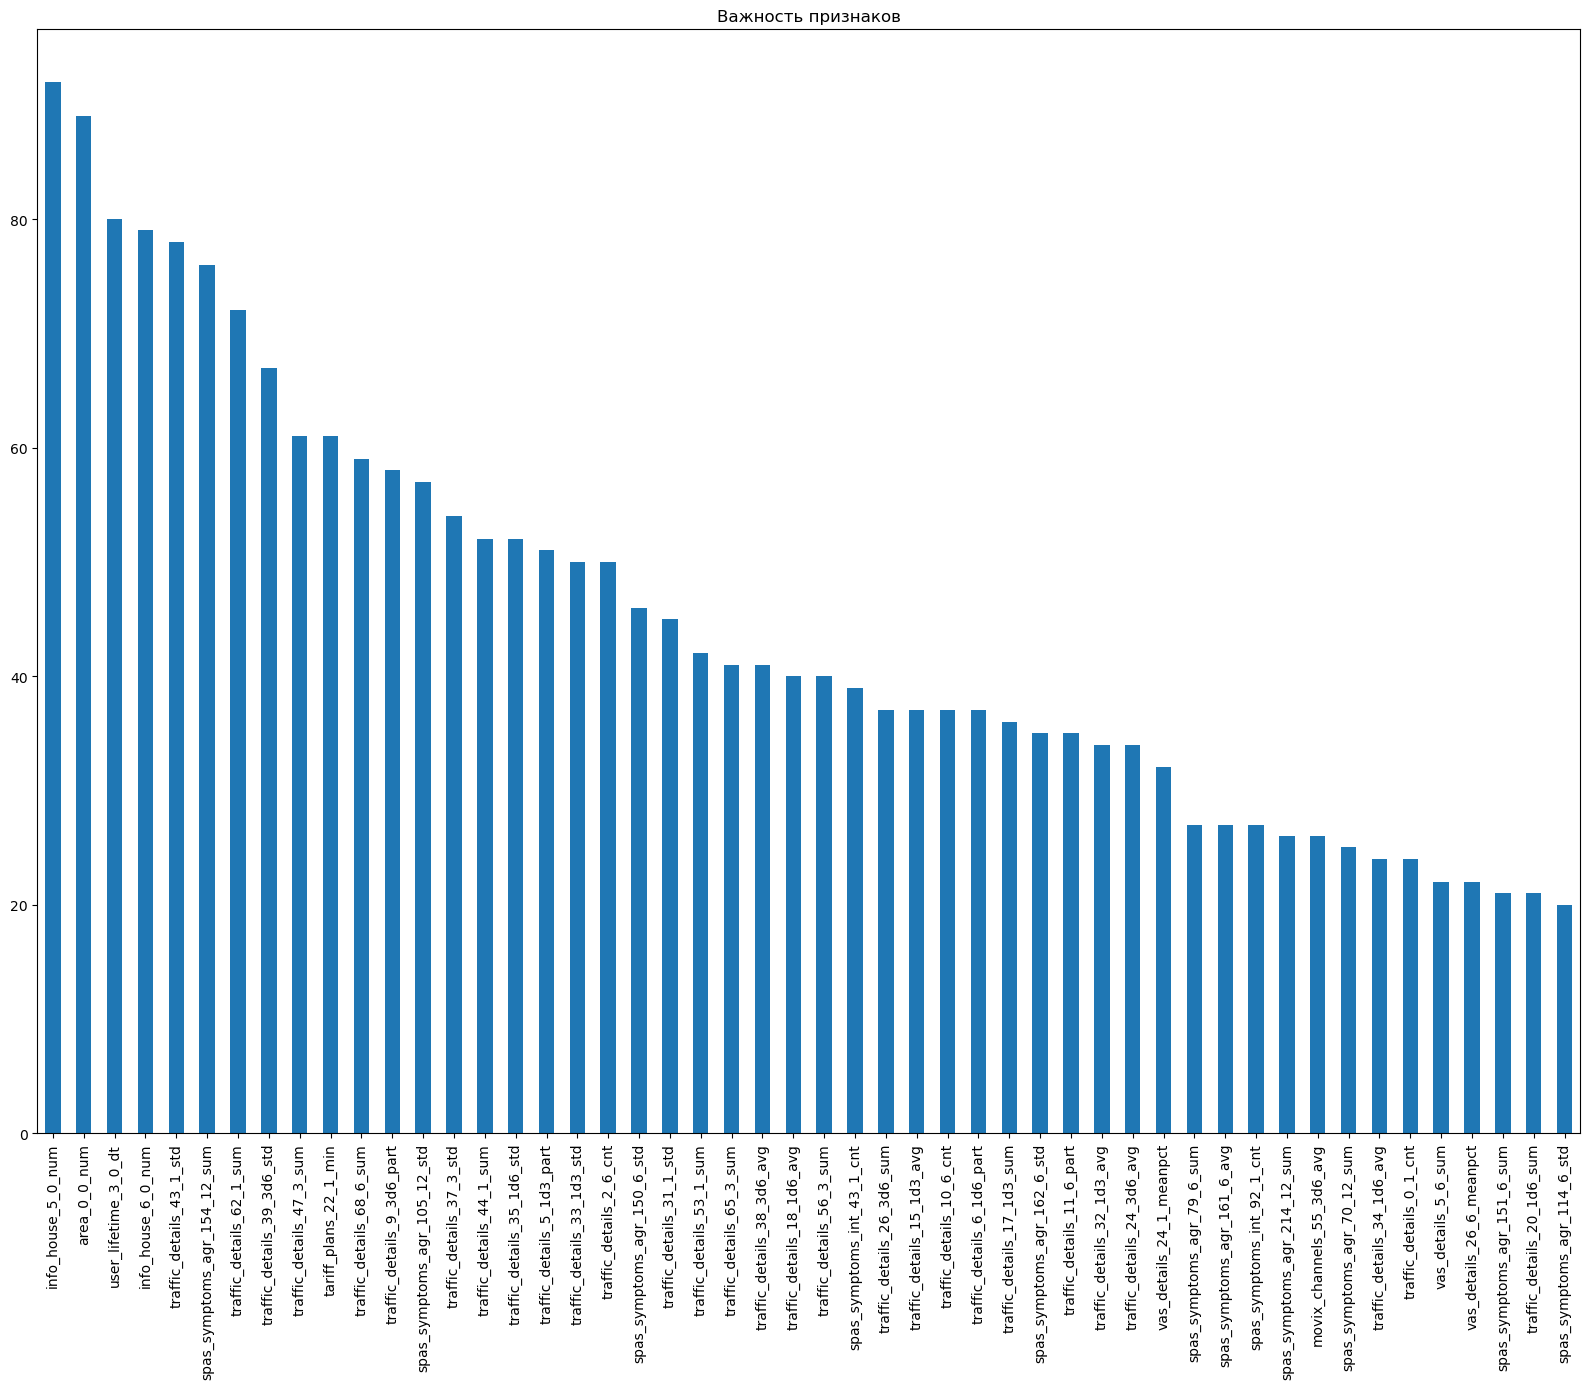

In [66]:
fig, ax = plt.subplots(figsize=(16,14))
lgbm_imp.sort_values(ascending=False).head(50).plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

In [67]:
important_futures = fitures_df['feature_names'].to_list()
important_futures

['info_house_5_0_num',
 'area_0_0_num',
 'user_lifetime_3_0_dt',
 'info_house_6_0_num',
 'traffic_details_43_1_std',
 'spas_symptoms_agr_154_12_sum',
 'traffic_details_62_1_sum',
 'traffic_details_39_3d6_std',
 'traffic_details_47_3_sum',
 'tariff_plans_22_1_min',
 'traffic_details_68_6_sum',
 'traffic_details_9_3d6_part',
 'spas_symptoms_agr_105_12_std',
 'traffic_details_37_3_std',
 'traffic_details_44_1_sum',
 'traffic_details_35_1d6_std',
 'traffic_details_5_1d3_part',
 'traffic_details_33_1d3_std',
 'traffic_details_2_6_cnt',
 'spas_symptoms_agr_150_6_std',
 'traffic_details_31_1_std',
 'traffic_details_53_1_sum',
 'traffic_details_65_3_sum',
 'traffic_details_38_3d6_avg',
 'traffic_details_18_1d6_avg',
 'traffic_details_56_3_sum',
 'spas_symptoms_int_43_1_cnt',
 'traffic_details_26_3d6_sum',
 'traffic_details_15_1d3_avg',
 'traffic_details_10_6_cnt',
 'traffic_details_6_1d6_part',
 'traffic_details_17_1d3_sum',
 'spas_symptoms_agr_162_6_std',
 'traffic_details_11_6_part',
 'traff

Посмотрим на полученный датасет с важными признаками:

In [68]:
columns_to_read = fitures_df['feature_names'].to_list() + ['target']

dataset_for_test = pd.read_parquet('dataset_train.parquet', engine='pyarrow', columns=columns_to_read)

In [69]:
dataset_for_test.head()

,info_house_5_0_num,area_0_0_num,user_lifetime_3_0_dt,info_house_6_0_num,traffic_details_43_1_std,spas_symptoms_agr_154_12_sum,traffic_details_62_1_sum,traffic_details_39_3d6_std,traffic_details_47_3_sum,tariff_plans_22_1_min,...,movix_channels_55_3d6_avg,spas_symptoms_agr_70_12_sum,traffic_details_34_1d6_avg,traffic_details_0_1_cnt,vas_details_5_6_sum,vas_details_26_6_meanpct,spas_symptoms_agr_151_6_sum,traffic_details_20_1d6_sum,spas_symptoms_agr_114_6_std,target
0,-0.148010,-0.389706,1.047656,0.195933,-0.003515,1.203344,-0.010768,0.440552,0.095315,-0.756059,...,NaN,0.336747,-0.475275,0.456141,NaN,NaN,-1.608666,-0.386911,-0.518307,0
1,-0.154880,-0.360158,1.084350,0.196460,-0.025559,1.349770,-0.048241,0.309751,-0.050774,-0.756059,...,NaN,0.336747,-0.110205,0.241262,NaN,NaN,-1.608666,-0.271295,-0.518307,0
2,-0.159672,NaN,0.948712,0.186659,-0.012550,-3.362484,-0.024261,0.931132,-0.043705,-0.031473,...,NaN,0.336747,-0.029765,0.241262,NaN,NaN,-1.567160,-0.535423,3.229041,1
3,-0.137583,-0.104079,0.984096,0.200200,-0.019408,1.416327,0.017605,0.342601,-0.045270,-0.031473,...,NaN,0.336747,1.335890,0.456141,NaN,NaN,-1.650172,3.909695,-0.518307,0
4,-0.122424,1.762342,0.948057,0.200190,-0.002080,-2.723534,0.308970,-2.726170,-0.000405,-0.031473,...,NaN,0.336747,-1.650221,0.241262,NaN,NaN,-1.567160,-1.191407,-0.518307,0


In [70]:
dataset_for_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 51 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   info_house_5_0_num            696471 non-null  float64
 1   area_0_0_num                  467367 non-null  float64
 2   user_lifetime_3_0_dt          696827 non-null  float64
 3   info_house_6_0_num            696471 non-null  float64
 4   traffic_details_43_1_std      686189 non-null  float64
 5   spas_symptoms_agr_154_12_sum  692032 non-null  float64
 6   traffic_details_62_1_sum      686189 non-null  float64
 7   traffic_details_39_3d6_std    686189 non-null  float64
 8   traffic_details_47_3_sum      686189 non-null  float64
 9   tariff_plans_22_1_min         697313 non-null  float64
 10  traffic_details_68_6_sum      686189 non-null  float64
 11  traffic_details_9_3d6_part    686189 non-null  float64
 12  spas_symptoms_agr_105_12_std  691863 non-nul

Посмотрим на корреляцию с таргетом, затем друг с другом. отбросим признаки с высокой корреляцией.

In [71]:
corr_matrix = dataset_for_test.corr().abs()
corr_matrix

,info_house_5_0_num,area_0_0_num,user_lifetime_3_0_dt,info_house_6_0_num,traffic_details_43_1_std,spas_symptoms_agr_154_12_sum,traffic_details_62_1_sum,traffic_details_39_3d6_std,traffic_details_47_3_sum,tariff_plans_22_1_min,...,movix_channels_55_3d6_avg,spas_symptoms_agr_70_12_sum,traffic_details_34_1d6_avg,traffic_details_0_1_cnt,vas_details_5_6_sum,vas_details_26_6_meanpct,spas_symptoms_agr_151_6_sum,traffic_details_20_1d6_sum,spas_symptoms_agr_114_6_std,target
info_house_5_0_num,1.000000,0.040719,0.004210,0.206370,0.001022,0.061681,0.006272,0.027056,0.005016,0.051886,...,0.000778,0.016247,0.014398,0.019609,0.015922,0.020676,0.149844,0.029843,0.052582,0.003528
area_0_0_num,0.040719,1.000000,0.064324,0.037293,0.001369,0.013087,0.005349,0.003732,0.008863,0.047930,...,0.008388,0.037451,0.003462,0.042355,0.033817,0.021111,0.027707,0.012180,0.023529,0.002379
user_lifetime_3_0_dt,0.004210,0.064324,1.000000,0.069815,0.003282,0.111928,0.000753,0.015377,0.003746,0.102897,...,0.000062,0.234804,0.015769,0.014335,0.003320,0.028106,0.043178,0.128062,0.136412,0.005310
info_house_6_0_num,0.206370,0.037293,0.069815,1.000000,0.002599,0.218296,0.004802,0.073113,0.006387,0.104209,...,0.009425,0.015781,0.052942,0.010441,0.005593,0.018530,0.450602,0.021693,0.025740,0.006218
traffic_details_43_1_std,0.001022,0.001369,0.003282,0.002599,1.000000,0.006470,0.393263,0.010201,0.178213,0.011179,...,0.003606,0.003012,0.064157,0.004255,0.003394,0.006634,0.009993,0.035956,0.002077,0.000607
spas_symptoms_agr_154_12_sum,0.061681,0.013087,0.111928,0.218296,0.006470,1.000000,0.004876,0.062147,0.005199,0.134159,...,0.017353,0.474469,0.032524,0.056860,0.006961,0.002408,0.358694,0.262773,0.398227,0.012160
traffic_details_62_1_sum,0.006272,0.005349,0.000753,0.004802,0.393263,0.004876,1.000000,0.008562,0.079455,0.012306,...,0.003127,0.003523,0.070433,0.011117,0.009689,0.001464,0.007172,0.038514,0.001124,0.000056
traffic_details_39_3d6_std,0.027056,0.003732,0.015377,0.073113,0.010201,0.062147,0.008562,1.000000,0.012079,0.021190,...,0.019635,0.015925,0.376994,0.035235,0.000877,0.004816,0.097908,0.207826,0.015815,0.000256
traffic_details_47_3_sum,0.005016,0.008863,0.003746,0.006387,0.178213,0.005199,0.079455,0.012079,1.000000,0.040827,...,0.005731,0.000230,0.000824,0.010562,0.004618,0.008610,0.017528,0.006383,0.006442,0.001561
tariff_plans_22_1_min,0.051886,0.047930,0.102897,0.104209,0.011179,0.134159,0.012306,0.021190,0.040827,1.000000,...,0.004567,0.157422,0.012013,0.011421,0.015581,0.098534,0.039786,0.088052,0.058090,0.013955


In [72]:
dataset_for_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Data columns (total 51 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   info_house_5_0_num            696471 non-null  float64
 1   area_0_0_num                  467367 non-null  float64
 2   user_lifetime_3_0_dt          696827 non-null  float64
 3   info_house_6_0_num            696471 non-null  float64
 4   traffic_details_43_1_std      686189 non-null  float64
 5   spas_symptoms_agr_154_12_sum  692032 non-null  float64
 6   traffic_details_62_1_sum      686189 non-null  float64
 7   traffic_details_39_3d6_std    686189 non-null  float64
 8   traffic_details_47_3_sum      686189 non-null  float64
 9   tariff_plans_22_1_min         697313 non-null  float64
 10  traffic_details_68_6_sum      686189 non-null  float64
 11  traffic_details_9_3d6_part    686189 non-null  float64
 12  spas_symptoms_agr_105_12_std  691863 non-nul

## Предсказание модели с новыми признаками

In [83]:
features_fin = dataset_for_test.drop(['target'], axis=1)
target_fin = dataset_for_test['target']

In [84]:
features_downsampled_fin, target_downsampled_fin = downsample(features_fin, target_fin, 0.01)

In [85]:
model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(features_downsampled_fin, target_downsampled_fin)

LGBMClassifier(random_state=42)

Матрицы ошибок:

In [86]:
lgbm_predicted = model_lgbm.predict(features_downsampled_fin)

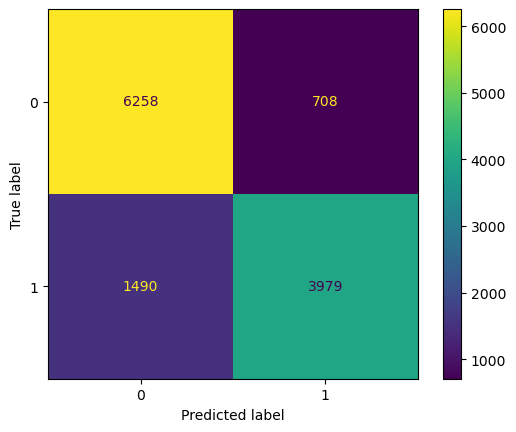

In [87]:
cm = confusion_matrix(target_downsampled_fin, lgbm_predicted, labels=model_lgbm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lgbm.classes_)
disp.plot()

plt.show()

In [88]:
lgbm_predicted = model_lgbm.predict(features_fin)

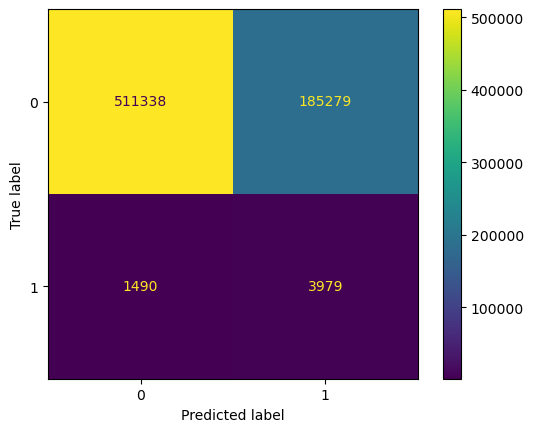

In [89]:
cm = confusion_matrix(target_fin, lgbm_predicted, labels=model_lgbm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lgbm.classes_)
disp.plot()

plt.show()